# A Mean Reversion Strategy with 2.11 Sharpe

In [38]:
from IPython.display import display, HTML

In [39]:
HTML('<div class="substack-post-embed"><p lang="en">A Mean Reversion Strategy with 2.11 Sharpe by Quantitativo</p><p>Trading rules to trade QQQ with 5x better risk-adjusted return without the large drawdowns</p><a data-post-link href="https://www.quantitativo.com/p/a-mean-reversion-strategy-with-211">Read on Substack</a></div><script async src="https://substack.com/embedjs/embed.js" charset="utf-8"></script>')

To demonstrate the current capabilities of the `baxter` backtesting framework, we test a mean reversion strategy based on a few indicators and trading a single ETF asset. The analysis is based on an analysis made by **Quantitativo** and is linked to above.

_Mean reversion_ refers to a statistical phenomenon where a time series, after a period of diverging away from its mean value, reverts back to said value. It reflects the effect that the market tends to bounce back once it drops too far below a certain threshold. In this case the deviation from the mean is captured by technical indicators which will be calculated below.

## Imports

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf
import datetime

from baxter.LoopTester import LoopTester
from baxter.Strategy import Strategy

import warnings

In [41]:
warnings.filterwarnings('ignore')

In [42]:
sns.set_style('whitegrid')
sns.set_theme(rc={'figure.figsize':(12, 6)})
idx = pd.IndexSlice

## Data Acquisition

First we download the relevant data for the experiment and do some data cleaning.

In [56]:
END = datetime.datetime(2024, 5, 17)
START = datetime.datetime(1999, 3, 10)

asset = yf.download('QQQ', start=START, end=END)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [57]:
asset = asset.droplevel('Ticker', axis=1)
asset.columns.name = None
display(asset)

,Close,High,Low,Open,Volume
Date,,,,,
1999-03-10,43.184204,43.263490,42.523491,43.237061,5232000
1999-03-11,43.395660,43.752446,42.549947,43.501375,9688600
1999-03-12,42.338509,43.263507,41.994938,43.237079,8743600
1999-03-15,43.554211,43.607068,42.206356,42.655641,6369000
1999-03-16,43.924210,44.109209,43.263496,43.739210,4905800
...,...,...,...,...,...
2024-05-10,438.373260,440.604496,436.826273,438.849268,27116600
2024-05-13,439.384735,440.386321,437.966668,440.287149,22994200
2024-05-14,442.210968,442.746473,438.769906,438.958324,34478300


,Close,High,Low,Open,Volume
Date,,,,,
2007-01-11,58.598026,58.598026,58.452115,58.586351,129700
2007-01-12,58.306290,58.370491,58.306290,58.370491,700
2007-01-16,58.411316,58.411316,58.347114,58.387970,2300
2007-01-17,58.399609,58.399609,58.399609,58.399609,1800
2007-01-18,58.376263,58.376263,58.236189,58.265373,4400
...,...,...,...,...,...
2024-05-10,94.942368,95.158598,94.848357,95.149194,431100
2024-05-13,95.149200,95.403036,95.130401,95.403036,271900
2024-05-14,95.544037,95.638054,95.233804,95.450027,341700


## The Strategy

The entry and exit rules of the strategy are as follows

* **Go long** when **the asset closes below the lower band** and **the IBS is lower 0.3**
* **Close the trade** whenever **the asset close is higher than its yesterday's high**

### Indicators

Below are calculated the indicators that are used to signal the entry and exit rules. All the calculated time series are collected in a single dataframe called `indicators` with a `DateTimeIndex` identical to that of `asset` so that each set of indicators can straight forwardly be compared at the same point in time by the `Strategy` instance.

In [45]:
indicators = pd.DataFrame(index=asset.index)

#### Rolling mean of **High minus Low** over the last 25 days

In [46]:
indicators['hml'] = (asset.High - asset.Low).rolling(25).mean()

#### Internal Bar Strength Indicator

In [47]:
indicators['IBS'] = (asset.Close - asset.Low) / (asset.High - asset.Low)

#### Lower Band

In [48]:
indicators['lband'] = asset.High.rolling(10).max() - 2.5 * indicators.hml

#### OHLCV prices of the asset

Since the asset itself indicates entry and exit signals, it is included as one of the indicators. Note that the indicator `asset_high` refers to the previous day compared to the other indicators, so we `.shift` yesterday's high forward to today so that it appears at the same point in time as the other indicator values.

In [63]:
indicators['asset_close'] = asset.Close
indicators['asset_high'] = asset.shift(1).High

In [50]:
display(indicators)

,hml,IBS,lband,spy_close,spy_high
Date,,,,,
1999-03-10,NaN,0.892857,NaN,43.184204,NaN
1999-03-11,NaN,0.703297,NaN,43.395660,43.263490
1999-03-12,NaN,0.270833,NaN,42.338509,43.752446
1999-03-15,NaN,0.962264,NaN,43.554211,43.263507
1999-03-16,NaN,0.781250,NaN,43.924210,43.607068
...,...,...,...,...,...
2024-05-10,5.851983,0.409448,425.974537,438.373260,437.917099
2024-05-13,5.817871,0.586062,426.059819,439.384735,440.604496
2024-05-14,5.746869,0.865335,428.379301,442.210968,440.386321


#### Strategy Implementation

The mean reversion strategy is a subclass of the `Strategy` class and must therefore implement the `long`, `close` and `short` methods which define the strategy rules for each point in time. Since this is a long only strategy, the short method is implemented by returning `False`.

In [65]:
class MeanReversion(Strategy):
    def long(self, indicator):
        return (indicator.asset_close < indicator.lband) & (indicator.IBS < 0.3)
        
    def close(self, indicator):
        return (indicator.asset_close > indicator.asset_high)
                
    def short(self, indicator):
        return False

An instance of the `MeanReversion` strategy is initiated by passing the previously calculated `indicators`, which are now recognized in the strategy methods.

In [66]:
mr = MeanReversion(indicators)

## Backtest

Finally, we initialize a `LoopTester` instance, passing the strategy instance, the open and close prices of the asset we wish to trade, and a benchmark in the form of the closing prices of the asset, corresponding to a simple buy and hold strategy.

CPU times: user 961 ms, sys: 4.4 ms, total: 965 ms
Wall time: 991 ms


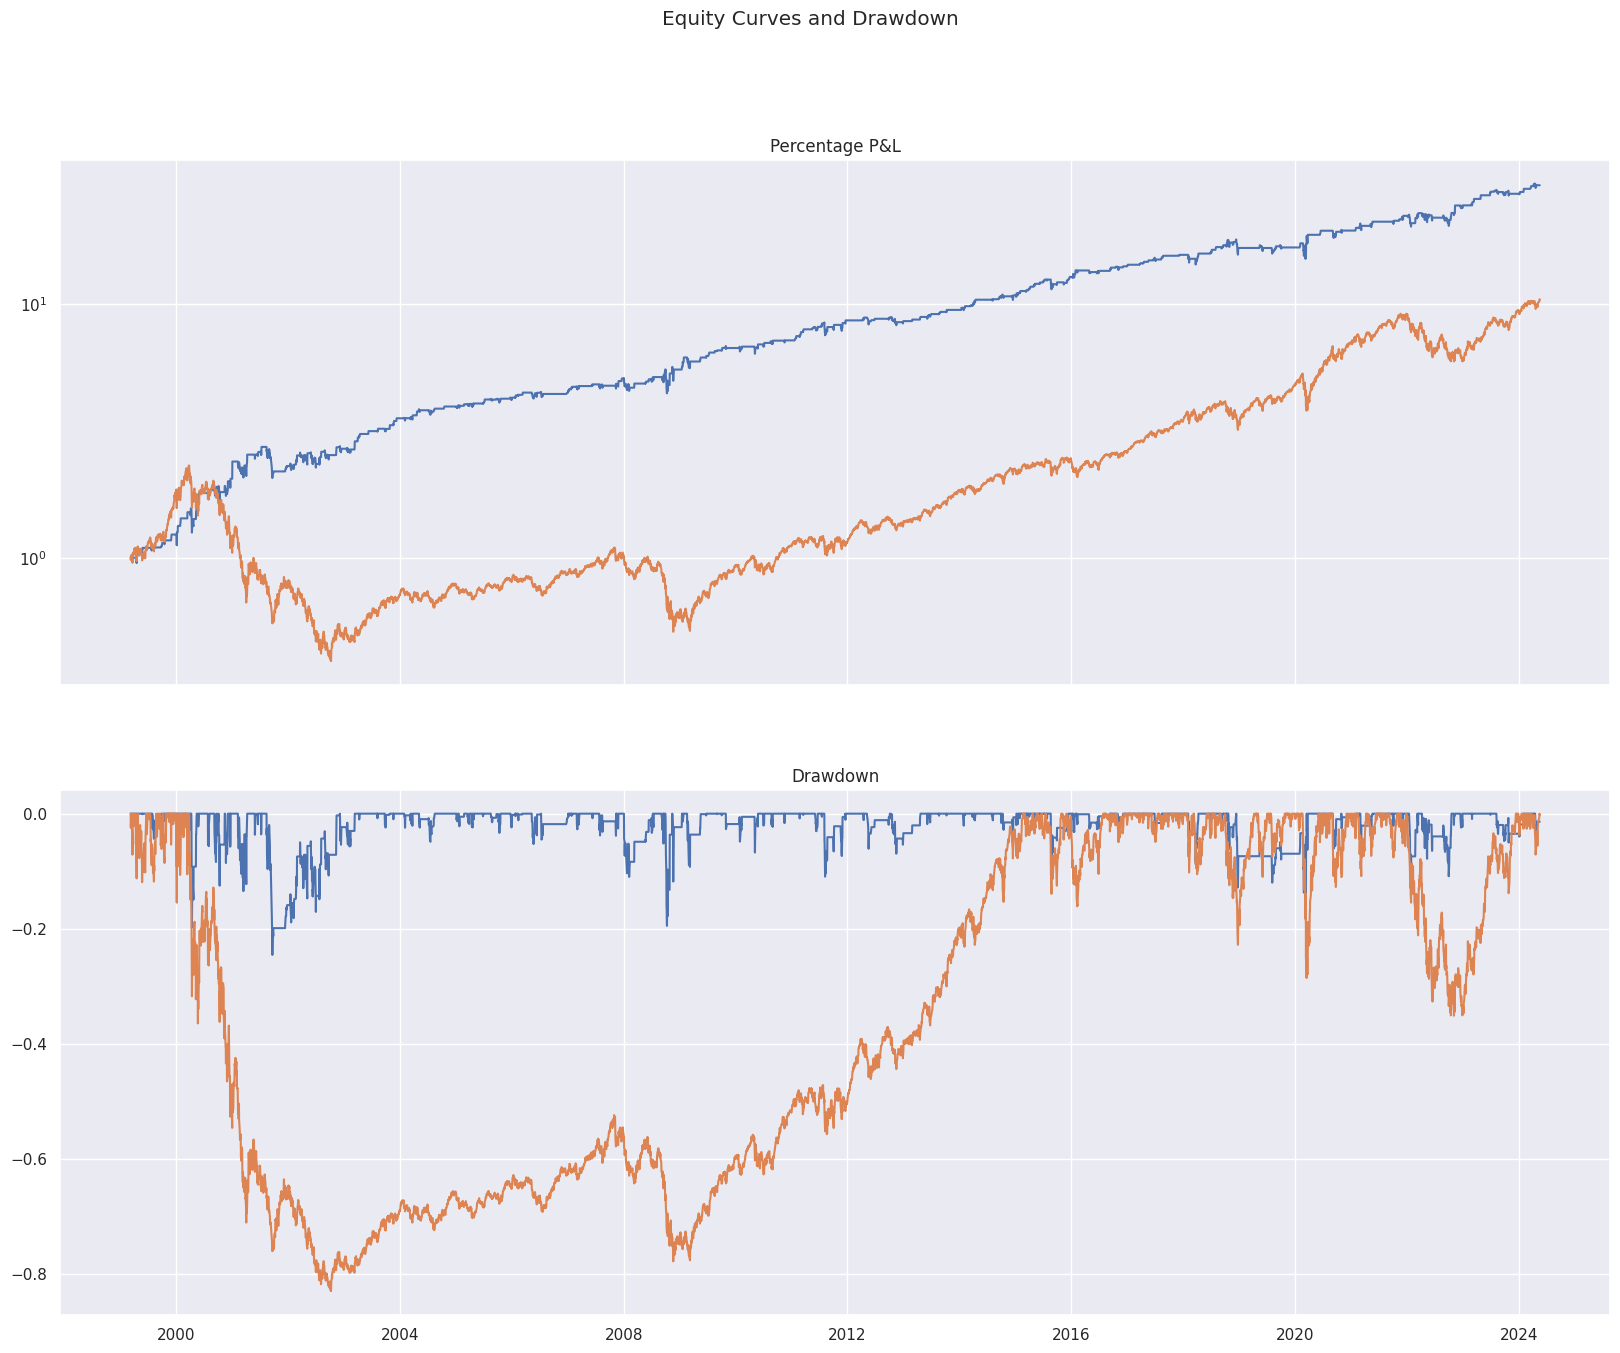

In [67]:
%%time
lt = LoopTester(mr, asset[["Open", "Close"]], asset[["Close"]])
lt.run()

Above we see a steady equity curve beating out the benchmark. Below is the drawdown for the strategy, and it suggests significantly smaller drawdowns than the benchmark.

To see the metrics calculated by the backtest, simply access the `metrics` attribute of the `LoopTester` instance `lt`.

In [54]:
lt.metrics

,value
Sharpe Ratio (annualized),2.023066
Sortino Ratio (annualized),3.163382
Compounded Annual Growth Rate,0.143567
Beta,0.599441
Max Drawdown,-0.245581
Average Drawdown,-0.019503
Max Drawdown Duration,481.000000
Average Drawdown Duration,67.000000
Total # of Drawdowns,137.000000
Annual # of Drawdowns,5.446285
